# The data is taken from the cats vs dogs Kaggle competition

We have 1. training data and 2. the kaggle competition test data

We will train our model using the training data but we will keep a portion of images of this dataset aside to test our model. That we keep the real kaggle test dataset fresh for the actual competition test.

##### To install opencv was a pain
```
brew install opencv3 --with-python3 --c++11 --with-contrib

brew link --force opencv3

mkdir -p /Users/danielhaggerty/Library/Python/3.6/lib/python/site-packages

echo 'import site; site.addsitedir("/usr/local/lib/python3.6/site-packages")' >> /Users/danielhaggerty/Library/Python/3.6/lib/python/site-packages/homebrew.pth

pip3 install opencv-python // redundant

pip3 install tensorflow

pip3 install tflearn

pip install tqdm
```

In [1]:
# Bring in data and preprocess
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

TRAIN_DIR = 'train'
TEST_DIR = 'test1'
# length height
IMG_SIZE_W = 250
IMG_SIZE_H = 100# forces all images to 50x50, 1000 429
LR = 1e-3 # 0.01, what is this and why 0.001

# LR(learning rate), 6 convolutional layers
# we can add more layers in convnet
MODEL_NAME = 'TF_W_H_sodas-{}-{}.model'.format(LR, '6-conv-basic-video')

In [2]:
# Process data
# Features and labels
# Features - will convert to a grayscale 2d array
# labels on images eg cat.9990.jpg dog.907.jpg
# Thus, if we split 'dog.907.jpg' on period... [-1]=jpg, [-2]=907, [-3]=dog

def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'correct': return [1,0]
    elif word_label == 'incorrect': return [0,1]

In [3]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        # resize and gray
        # do not grayscale
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE_W, IMG_SIZE_H))
        # put all into array
        training_data.append([np.array(img), np.array(label)])
    # shuffle in place
    shuffle(training_data)
    np.save('TF_train_data.npy', training_data)
    return training_data

In [4]:
# The training data is all the labelled images, dog 1 etc
# The image has the features and the label is dog or cat
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        # test data is just a number
        img_num = img.split('.')[0]
        img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE), (IMG_SIZE_W, IMG_SIZE_H))
        #  will allow us iterate thru, make predictions and store to csv
        testing_data.append([np.array(img), img_num])
        
    np.save('TF_test_data.npy', testing_data)
    return testing_data

In [5]:
# we can train data
train_data = create_train_data()

100%|██████████| 821/821 [00:19<00:00, 41.28it/s]


In [6]:
# copied from https://pythonprogramming.net/tflearn-machine-learning-tutorial/

import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

# needed as the notebook is continually running the graph
import tensorflow as tf
tf.reset_default_graph

convnet = input_data(shape=[None, IMG_SIZE_W, IMG_SIZE_H, 1], name='input')

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 2, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

# 2 = dog/cat, and learning_rate = LR (0.001)
convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


Two errors?

1.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)

2.

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
WARNING:tensorflow:From /Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/tflearn/initializations.py:119: UniformUnitScaling.__init__ (from tensorflow.python.ops.init_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.

Both seemed to be cured with

```
pip3 install h5py
```

In [7]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

INFO:tensorflow:Restoring parameters from /Users/danielhaggerty/Documents/tf/soda/TF_W_H_sodas-0.001-6-conv-basic-video.model
model loaded!


In [8]:
# Train data is all but last 500
train = train_data[:-100] 

# test is last 500
test = train_data[-100:]

In [9]:
# In 'train' variable above, [0] was image data, [1] will be label

# This data getting fit
# X = feature sets
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE_W, IMG_SIZE_H, 1)
# Y = labels
Y = [i[1] for i in train]
# This data gettig tested
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE_W, IMG_SIZE_H, 1)
test_y = [i[1] for i in test]

In [10]:
# Train
model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 119  | total loss: 11.73906 | time: 25.585s
| Adam | epoch: 005 | loss: 11.73906 - acc: 0.4902 -- iter: 704/721
Training Step: 120  | total loss: 11.57253 | time: 29.301s
| Adam | epoch: 005 | loss: 11.57253 - acc: 0.4974 | val_loss: 11.51293 - val_acc: 0.5000 -- iter: 721/721
--


In [11]:
# Type into shell
# tensorboard --logdir=/Users/danielhaggerty/Documents/tf/soda/log
# goto http://dan:6006/#scalars

In [12]:
# if happy with model we can save
model.save(MODEL_NAME)

INFO:tensorflow:/Users/danielhaggerty/Documents/tf/soda/TF_W_H_sodas-0.001-6-conv-basic-video.model is not in all_model_checkpoint_paths. Manually adding it.


### we can do a model load by running the above cell
```
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')
```

### then when we rerun `model.fit()` it should further improve the model

100%|██████████| 17/17 [00:01<00:00, 11.41it/s]


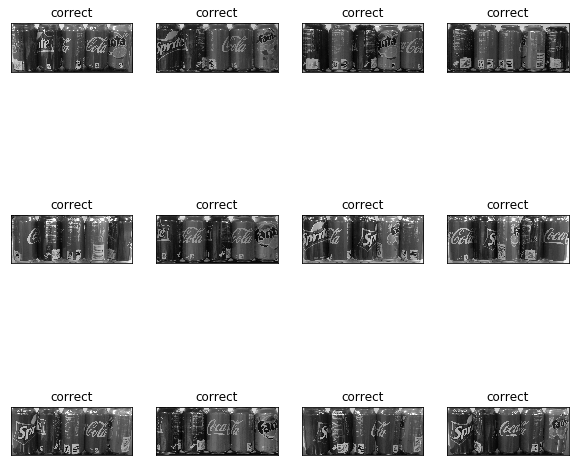

In [13]:
import matplotlib.pyplot as plt

# if we dont have file yet (we dont)
test_data = process_test_data()

# if we already have saved copy
# test_data = np.load('test_data.py')

fig = plt.figure(figsize=(10, 10))

# iterate thru 1st 12 test_data
for num, data in enumerate(test_data[:12]):
    # cat [1,0]
    # dog [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE_W, IMG_SIZE_H, 1)
    
    # predict takes a list and outputs
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='correct'
    else: str_label = 'incorrect'

    
    # plot the gray img with no axes
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

In [14]:
# To put all into csv
with open('results.csv', 'w') as f:
    f.write('id,label\n')

In [15]:
# To put all into csv
with open('results.csv', 'a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]   
        orig = img_data
        data = img_data.reshape(IMG_SIZE_W, IMG_SIZE_H, 1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num, model_out[1]))

100%|██████████| 17/17 [00:00<00:00, 83.59it/s]


In [16]:
# tensorboard --logdir=foo/Users/danielhaggerty/Documents/tf/soda/log